# Accidental Opiate Overdose Deaths
### Looking at Features of Prescribers

This [Kaggle dataset](https://www.kaggle.com/apryor6/us-opiate-prescriptions/home) contains information on prescription opiate overdoses by prescriber. From the Kaggle description:
>This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. 

Due to the large and often binarized nature of this dataset, I decided to explore it with some supervised and unsupervised modeling techniques. I first looked at this dataset using a Random Forest Classifier to predict the boolean value for whether or not the prescriber prescribed opiate drugs more than 10 times in the year. 

In [126]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import KMeans, k_means, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [77]:
opiods = pd.read_csv('./opioids.csv')
overdoses = pd.read_csv('./overdoses.csv')
prescribers = pd.read_csv('./prescriber-info.csv')

In [78]:
prescribers.shape

(25000, 256)

In [79]:
prescribers.fillna('Unspecified', inplace=True) # Specialty column missing data

In [80]:
prescribers.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [81]:
specialty_dummies = pd.get_dummies(prescribers['Specialty'])
state_dummies = pd.get_dummies(prescribers['State'])

In [82]:
prescribers['Opioid.Prescriber'].value_counts()

1    14688
0    10312
Name: Opioid.Prescriber, dtype: int64

In [83]:
prescribers['Gender'] = prescribers['Gender'].map({'M': 1, 'F': 0})

In [72]:
X = pd.concat([prescribers.drop(['State','Specialty','Credentials','NPI','Opioid.Prescriber'], axis=1),
           specialty_dummies, state_dummies], axis=1)
y = prescribers['Opioid.Prescriber']

In [73]:
X.dtypes.value_counts()

int64    251
uint8    166
dtype: int64

In [74]:
y.value_counts()

1    14688
0    10312
Name: Opioid.Prescriber, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [20]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('rf', RandomForestClassifier(random_state=24))])

In [21]:
params = {
    'rf__n_estimators': [10, 30, 50],
    'rf__max_features': ['auto','log2', 0.25, 0.5]
}

gs = GridSearchCV(pipe, params, scoring='accuracy')

In [22]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i...timators=10, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [10, 30, 50], 'rf__max_features': ['auto', 'log2', 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
gs.score(X_train, y_train)

0.99856

In [24]:
gs.score(X_test, y_test)

0.92544000000000004

In [25]:
gs.best_params_

{'rf__max_features': 0.25, 'rf__n_estimators': 50}

In [26]:
feat_imps = list(gs.best_estimator_.steps[1][1].feature_importances_)

In [27]:
features = pd.DataFrame(list(zip(X.columns, feat_imps)), columns=['Feature','Importance'])

In [28]:
top_feats = features.sort_values('Importance', ascending=False).head(10)
top_feats.set_index('Feature', inplace=True)

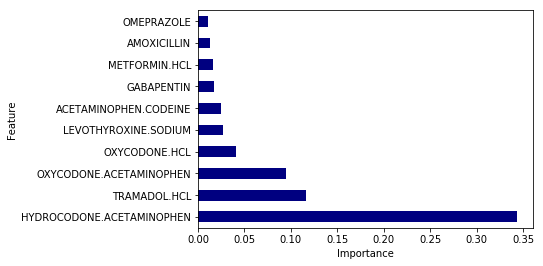

In [29]:
top_feats['Importance'].plot(kind='barh', color='navy')
plt.ylabel('Feature')
plt.xlabel('Importance');
# This isn't surprising at all
# But what are amoxicillin and gabapentin doing there?

In [30]:
# look at it without hydrocodone acetaminophen?
# unsupervised learning, clustering to group providers into categories, use as feature

**K Means Labels**

In [124]:
def km_value_counts(max_clusters, data):
    for n in range(2, max_clusters):
        print (n, "Clusters \n")
        km=KMeans(n_clusters=n)
        model=km.fit(data)
        print(pd.Series(model.labels_).value_counts(), "\n")

In [125]:
km_value_counts(6, X) # unbalanced

2 Clusters 

0    23008
1     1992
dtype: int64 

3 Clusters 

0    21840
1     2656
2      504
dtype: int64 

4 Clusters 

0    21017
3     2835
1      992
2      156
dtype: int64 

5 Clusters 

0    20880
3     2787
2     1081
1      174
4       78
dtype: int64 



**DB Scan Labels**

In [127]:
db=DBSCAN()

In [128]:
dbmodel = db.fit(X)

In [130]:
pd.Series(dbmodel.labels_).value_counts() # also wicked unbalanced

-1     24869
 3        11
 0        10
 5         8
 6         8
 11        7
 10        7
 4         7
 9         6
 7         6
 12        6
 13        6
 19        6
 14        6
 17        6
 15        6
 8         5
 18        5
 2         5
 1         5
 16        5
dtype: int64

It doesn't seem like unsupervised learning will help create a valuable feature for this model, although DBSCAN is helpful for identifying outliers. 

In [131]:
X['DB_Labels'] = dbmodel.labels_

In [135]:
label16=X[X['DB_Labels']==16].copy()

In [137]:
label16

,Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,UT,VA,VI,VT,WA,WI,WV,WY,ZZ,DB_Labels
5194,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
10860,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
12573,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
18458,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
19681,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16


In [142]:
label16.drop(["DB_Labels", "Gender"], axis=1).sum(axis=1)

5194     13
10860    13
12573    13
18458    13
19681    13
dtype: int64

In [148]:
sums16 = pd.DataFrame(label16.drop(["DB_Labels", "Gender"], axis=1).sum(axis=0), columns=['Sums'])

In [151]:
sums16.query("Sums > 0") # All Ohio dentists that only prescribed Amoxicillin

,Sums
AMOXICILLIN,55
Dentist,5
OH,5


In [152]:
label3=X[X['DB_Labels']==3].copy()

In [153]:
label3

,Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,UT,VA,VI,VT,WA,WI,WV,WY,ZZ,DB_Labels
682,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1819,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9480,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
14627,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
17613,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
18682,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
18807,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
20242,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
20647,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
22689,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [155]:
sums3 = pd.DataFrame(label3.drop(["DB_Labels", "Gender"], axis=1).sum(axis=0), columns=['Sums'])

In [156]:
sums3.query("Sums > 0") # Same but for Cali
# These are outliers but we'd still want to keep them in the model

,Sums
AMOXICILLIN,143
Dentist,11
CA,11


In [157]:
def explore_outliers(labels):
    for n in labels:
        df=X[X['DB_Labels']==n].copy()
        sums=pd.DataFrame(df.drop(["DB_Labels", "Gender"], axis=1).sum(axis=0), columns=['Sums'])
        print("Label",n)
        print(sums.query("Sums > 0"), "\n")

In [158]:
explore_outliers([lab for lab in dbmodel.labels_ if lab != -1])

Label 0
             Sums
AMOXICILLIN   120
Dentist        10
CA             10 

Label 1
             Sums
AMOXICILLIN    70
Dentist         5
IL              5 

Label 2
             Sums
AMOXICILLIN    85
Dentist         5
PA              5 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 5
             Sums
AMOXICILLIN   128
Dentist         8
CA              8 

Label 6
             Sums
AMOXICILLIN    88
Dentist         8
CA              8 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 7
             Sums
AMOXICILLIN   102
Dentist         6
NY              6 

Label 8
             Sums
AMOXICILLIN    65
Dentist         5
NY              5 

Label 7
        

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 18
             Sums
AMOXICILLIN    70
Dentist         5
MD              5 

Label 4
             Sums
AMOXICILLIN    98
Dentist         7
NY              7 

Label 15
             Sums
AMOXICILLIN    66
Dentist         6
NY              6 

Label 7
             Sums
AMOXICILLIN   102
Dentist         6
NY              6 

Label 6
             Sums
AMOXICILLIN    88
Dentist         8
CA              8 

Label 15
             Sums
AMOXICILLIN    66
Dentist         6
NY              6 

Label 19
             Sums
AMOXICILLIN   108
Dentist         6
CA              6 

Label 3
             Sums
AMOXICILLIN   143
Dentist        11
CA             11 

Label 0
             Sums
AMOXICILLIN   120
Dentist        10
CA             10 

Label 6
             Sums
AMOXICILLIN    88
Dentist         8
CA              8 

Label 5
             Sums
AMOXICILLIN   128
Dentist         8
CA              8 

Label 19
   

All the outliers are dentists that only prescribe amoxicillin.